In [1]:
import pandas as pd
import numpy as np

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

import shap

C:\Users\littl\anaconda3\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def run_gb_grid_search(data: pd.DataFrame,
                       target: str,
                       drop_threshold: float = 0.75,
                       max_iter_mice: int = 12,
                       n_splits: int = 5,
                       random_state: int = 42):
    """
    Perform Gradient Boosting grid search with MICE imputation, then output top 3 models'
    confusion matrices and classification reports. Also output feature importances
    and SHAP values for the best model.

    Steps:
        1. Drop rows with missing ratio greater than drop_threshold.
        2. Separate features (X) and target (y).
        3. Use IterativeImputer (MICE) with max_iter=max_iter_mice for missing data imputation.
        4. Perform grid search (GridSearchCV) over GradientBoostingClassifier hyperparameters.
        5. Get top 3 best param sets (by mean_test_score), retrain them on entire data,
           and show confusion matrix & classification report.
        6. Print feature importances of the best model.
        7. Compute and visualize SHAP values for the best model.

    :param data: Input dataframe including the target column.
    :param target: Name of the target column.
    :param drop_threshold: Rows with missing ratio above this will be dropped (default=0.95).
    :param max_iter_mice: Iterations for IterativeImputer (MICE) (default=12).
    :param n_splits: Number of folds for cross-validation (default=5).
    :param random_state: Seed for reproducibility (default=42).
    :return: Trained best GradientBoostingClassifier model (after grid search).
    """

    # 1. Drop rows with too many missing values
    row_missing_ratio = data.isnull().sum(axis=1) / data.shape[1]
    data_cleaned = data.loc[row_missing_ratio <= drop_threshold].copy()
    
    # 2. Separate features (X) and target (y)
    y = data_cleaned[target]
    X = data_cleaned.drop(columns=[target])
    feature_names = X.columns  # Keep feature names for later use

    # 3. MICE imputation
    imputer = IterativeImputer(max_iter=max_iter_mice, random_state=random_state)
    X_imputed = imputer.fit_transform(X)
    
    # Define a parameter grid for GradientBoostingClassifier
    param_grid = {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "subsample": [0.6, 0.8, 1.0]
    }
    
    # Initialize the base model
    gb = GradientBoostingClassifier(random_state=random_state)
    
    # 4. Grid Search with StratifiedKFold cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(
        estimator=gb,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_imputed, y)

    # Print the best hyperparameters and score
    print("Best Parameters:", grid_search.best_params_)
    print("Best CV Score (accuracy):", grid_search.best_score_)
    
    # Retrieve the best estimator
    best_model = grid_search.best_estimator_

    # 5. Retrieve top 3 results and evaluate
    print("\n== Top 3 Parameter Sets and Their Scores ==")
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_results.sort_values(by="mean_test_score", ascending=False)
    
    # Select top 3
    top_10 = cv_results.head(10).copy()
    for rank, (_, row) in enumerate(top_10.iterrows(), start=1):
        print(f"\nRank {rank}:")
        print("Params:", row["params"])
        print("Mean CV Score:", row["mean_test_score"])
        
        # Re-train model on entire dataset with these params
        params = row["params"]
        model = GradientBoostingClassifier(random_state=random_state, **params)
        model.fit(X_imputed, y)
        
        # Predict on the same data (X_imputed) for demonstration
        y_pred = model.predict(X_imputed)
        
        # Print confusion matrix and classification report
        print("\nConfusion Matrix:")
        print(confusion_matrix(y, y_pred))
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

    # 6. Print the feature importances of the best model
    print("\n== Best Model Feature Importances ==")
    importances = best_model.feature_importances_
    feat_imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    print(feat_imp_df.to_string(index=False))
    
    # 7. Compute and visualize SHAP values for the best model
    print("\n== Computing SHAP values for the best model ==")
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_imputed)
    
    # Summary plot (if running in a notebook, this will display inline)
    shap.summary_plot(shap_values, X_imputed, feature_names=feature_names)

    return best_model


In [3]:
def main():
    """
    Main function for demonstration.
    Modify the CSV path, target column name as needed.
    """
    # Example: read data
    data = pd.read_csv(r"../data/final/nicu_30.csv")
    data = data.drop(columns=['SUBJECT_ID'])

    # Define target column
    target_column = "is_infected"

    # Run grid search for Gradient Boosting
    best_gb_model = run_gb_grid_search(
        data=data,
        target=target_column,
        drop_threshold=0.75,
        max_iter_mice=12
    )
    
    # Print out the final best model
    print("\nFinal Best Gradient Boosting Model:")
    print(best_gb_model)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.6}
Best CV Score (accuracy): 0.7903461698348513

== Top 3 Parameter Sets and Their Scores ==

Rank 1:
Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.6}
Mean CV Score: 0.7903461698348513

Confusion Matrix:
[[ 519  341]
 [  72 1887]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.60      0.72       860
         1.0       0.85      0.96      0.90      1959

    accuracy                           0.85      2819
   macro avg       0.86      0.78      0.81      2819
weighted avg       0.86      0.85      0.84      2819


Rank 2:
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}
Mean CV Score: 0.7896382096922514

Confusion Matrix:
[[ 479  381]
 [ 115 1844]]

Classification Report:
              precision    re

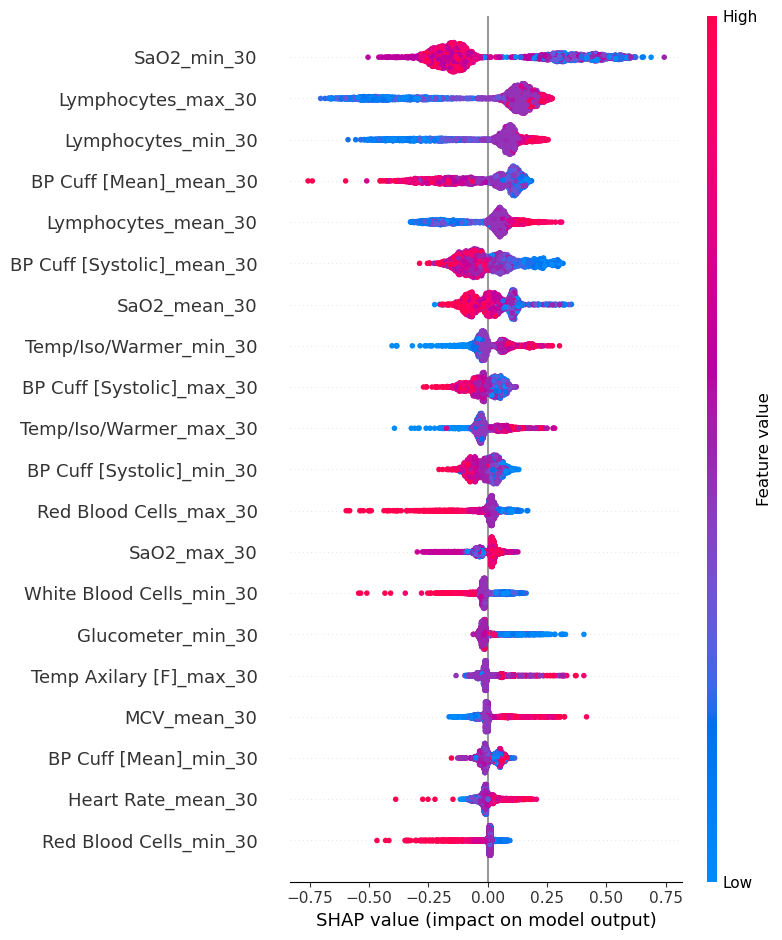


Final Best Gradient Boosting Model:
GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=50,
                           random_state=42, subsample=0.6)


In [4]:
if __name__ == "__main__":
    main()